# Fig 2 Deriving and validating a composite blood assay signature of pain-associated conditions

### This notebook contains the code for a secondary analyses for figure 1:
- Calculate and plot the composite blood assay signature
- Plot the performance of the signature in cross-sectional and longitudinal (4 and 9 year) predictions of pain conditions
- Plot the signature trajectories in the three pain condition groups and healthy control group using the subset of participants who had repeat blood panels collected at 4 years
- Validate a more sparse "routine assay" version of the signature in the All of Us

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import zscore
from scipy import stats
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind
import warnings

# This will ignore all warnings
warnings.simplefilter(action='ignore', category=Warning)

line_width = 0.5
fs = 7

sns.set_context(rc={"font.size":fs})   
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['figure.dpi'] = 300
plt.rc('mathtext',**{'default':'regular'})
plt.rcParams['font.size'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.pad'] = '1.5'
plt.rcParams['ytick.major.pad'] = '1.5'
plt.rcParams['axes.linewidth'] = line_width
plt.rcParams['xtick.major.width'] = line_width
plt.rcParams['ytick.major.width'] = line_width

color_mapping = {'Blood': '#9EB9F3',
 'Bone': '#F89C74',
 'PRS': '#DCB0F2',
 'Stacked': '#87C55F',
 'Psychosocial': '#C0BFC9'}

In [8]:
nci_cols_t0 = [
                    'NCI_fibromyalgia_T0',
                    'NCI_polymyalgia rheumatica_T0',
                    'NCI_cervical spondylosis_T0',
                    'NCI_joint pain_T0',
                    'NCI_back pain_T0',
                    'NCI_spine arthritis/spondylitis_T0',
                    'NCI_trapped nerve/compressed nerve_T0',
                    'NCI_sciatica_T0',
                    'NCI_hernia_T0',
                    'NCI_irritable bowel syndrome_T0',
                    'NCI_gastro-oesophageal reflux (gord) / gastric reflux_T0',
                    'NCI_arthritis (nos)_T0',
                    'NCI_osteoarthritis_T0',
                    'NCI_osteoporosis_T0',
                    'NCI_rheumatoid arthritis_T0',
                    'NCI_migraine_T0',
                    'NCI_headaches (not migraine)_T0',
                    'NCI_carpal tunnel syndrome_T0',
                    'NCI_angina_T0',
                    'NCI_endometriosis_T0',
                    'NCI_gout_T0',
                    'NCI_chronic fatigue syndrome_T0',
                    'NCI_ankylosing spondylitis_T0',
                    'NCI_trigemminal neuralgia_T0',
                    'NCI_crohns disease_T0',
                    'NCI_spinal stenosis_T0',
                    'NCI_peripheral neuropathy_T0',
                    'NCI_ulcerative colitis_T0',
                    'NCI_pulmonary embolism +/- dvt_T0',
                    'NCI_chronic obstructive airways disease/copd_T0',
                    'NCI_stroke_T0',
                    'NCI_multiple sclerosis_T0',
                    'NCI_psoriatic arthropathy_T0',
                    'NCI_Post Surgical Pain_T0',
                    # 'NCI_parkinsons disease_T0',
                    'NCI_disc disorder_T0',
                	# 'NCI_peripheral vascular disease_T0'
]

rename = {'joint pain': 'Joint Pain',
 'soft tissue inflammation': 'Soft Tissue Inf.',
 'spinal stenosis': 'Spinal Stenosis',
 'trapped nerve/compressed nerve': 'Trapped Nerve',
 'stroke': 'Stroke',
 'multiple sclerosis': 'Multiple Sclerosis',
 'chronic obstructive airways disease/copd': 'COPD',
 'sciatica': 'Sciatica',
 'back pain': 'Back Pain',
 'osteoporosis': 'Osteoporosis',
 'spine arthritis/spondylitis': 'Spine Arthritis',
 'peripheral neuropathy': 'Peripheral Neuropathy',
 'angina': 'Angina',
 'migraine': 'Migraine',
 'hernia': 'Hernia',
 'gout': 'Gout',
 'gastro-oesophageal reflux (gord) / gastric reflux': 'Gastric Reflux',
 'arthritis (nos)': 'Arthritis (Nos)',
 'endometriosis': 'Endometriosis',
 'cervical spondylosis': 'Cervical Spondylosis',
 'irritable bowel syndrome': 'IBS',
 'headaches (not migraine)': 'Non-Migraine Headaches',
 'chronic fatigue syndrome': 'Chronic Fatigue Synd.',
 'polymyalgia rheumatica': 'Polymyalgia Rheumatica',
 'ulcerative colitis': 'Ulcerative Colitis',
 'psoriasis': 'Psoriasis',
 'osteoarthritis': 'Osteoarthritis',
 'diverticular disease/diverticulitis': 'Diverticulitis',
 'rheumatoid arthritis': 'Rheumatoid Arthritis',
 'carpal tunnel syndrome': 'Carpal Tunnel Synd.',
 'disc disorder': 'Disc Disorder',
 'back problem': 'Back Problem',
 'pulmonary embolism +/- dvt': 'Pulmonary Embolism',
 'ankylosing spondylitis': 'Ankylosing Spondylitis',
 'fibromyalgia': 'Fibromyalgia',
 'trigemminal neuralgia': 'Trigemminal Neuralgia',
 'crohns disease': 'Crohns Disease',
 'parkinsons disease': 'Parkinsons Disease',
 'psoriatic arthropathy': 'Psoriatic Arthropathy',
 'multiple sclerosis': 'Multiple Sclerosis',
 'Post Surgical Pain': 'Post Surgical Pain',
 'peripheral vascular disease': 'Peripheral Vascular Disease'
         }

nci_cols_t1 = [i.replace('T0','T1') for i in nci_cols_t0]
nci_cols_t2 = [i.replace('T0','T2') for i in nci_cols_t0]
nci_cols_t3 = [i.replace('T0','T3') for i in nci_cols_t0]


In [9]:
# Loading in machine learning model results
diag_T0 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/first_occ/T0_diagnoses_clf-LR_lin.pickle')
diag_T0 = {key: value for key, value in diag_T0.items() if 'parkinson' not in key}
diag_T0 = {key: value for key, value in diag_T0.items() if 'peripheral vascular disease' not in key}

diag_T2 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/first_occ/T2_diagnoses_clf-LR_lin.pickle')
diag_T2 = {key: value for key, value in diag_T2.items() if 'parkinson' not in key}
diag_T2 = {key: value for key, value in diag_T2.items() if 'peripheral vascular disease' not in key}

## Visualizing the composite blood assay signature using a circos plot

In [15]:
blood_dic = {
 'CReactiveProtein_T0': 'CRP',
 'EosinophillCount_T0': 'Eos cnt.',
 'BasophileCount_T0': 'Baso cnt.',
 'MonocyteCount_T0': 'Mono cnt.',
 'NeutrophillCount_T0': 'Neut cnt.',
 'WhiteBloodCellLeukocyteCount_T0': 'WBC',
 'BasophilePercentage_T0': 'Baso %',
 'EosinophillPercentage_T0': 'Eos %',
 'MonocytePercentage_T0': 'Mono %',
 'NeutrophillPercentage_T0': 'Neut %',
 'LymphocyteCount_T0': 'Lymph cnt.',
 'LymphocytePercentage_T0': 'Lymph %',
 'Glucose_T0': 'Glu',
 'AlanineAminotransferase_T0': 'ALT',
 'AspartateAminotransferase_T0': 'AST',
 'AlkalinePhsophate_T0': 'ALP',
 'TotalBilirubin_T0': 'TBil',
 'Urea_T0': 'Urea',
 'Creatinine_T0': 'Cr',
 'Albumin_T0': 'Alb',
 'Calcium_T0': 'Ca',
 'TotalProtein_T0': 'TP',
 'Sodium_T0': 'Na',
 'Potassium_T0': 'K',
 'AlipoproteinA_T0': 'Apo-A',
 'AlipoproteinB_T0': 'Apo-B',
 'GammaGlutamyltransferase_T0': 'GGT',
 'Triglyceride_T0': 'TG',
 'VitaminD_T0': 'Vit D',
 'Testosterone_T0': 'Testo',
 'IGF1_T0': 'IGF1',
 'LDLDirect_T0': 'LDL-C',
 'Urate_T0': 'UA',
 'HDLCholesterol_T0': 'HDL-C',
 'Cholesterol_T0': 'TC',
 'CystatinC_T0': 'Cys C',
 'GlycatedHaemoglobin_T0': 'HbA1c',
 'HaematocritPercentage_T0': 'Hct',
 'HaemoglobinConcentration_T0': 'Hgb',
 'PlateletDistributionWidth_T0': 'PDW',
 'MeanPlateletThrombocyteVolume_T0': 'MPV',
 'PlateletCrit_T0': 'PCT',
 'PlateletCount_T0': 'PLT cnt.',
 'RedBloodCellErythrocyteCount_T0': 'RBC cnt.',
 'RedBloodCellErythrocyteDistributionWidth_T0': 'RDW',
 'HighLightScatterReticulocyteCount_T0': 'HLR cnt.',
 'HighLightScatterReticulocytePercentage_T0': 'HLR %',
 'ReticulocyteCount_T0': 'Retic cnt.',
 'ReticulocytePercentage_T0': 'Retic %',
 'ImmatureReticulocyteFraction_T0': 'IRF',
 'MeanReticulocyteVolume_T0': 'Retic-Vol',
 'MeanSpheredCellVolume_T0': 'SCV',
 'NucleatedRedBloodCellCount_T0': 'nRBC cnt.',
 'NucleatedRedBloodCellPercentage_T0': 'nRBC %'
}

In [16]:
# Extracted these from barplot codes above, will need to change order if modeling changes
auc_pivot_cols = ['Gout',
 'Angina',
 'Polymyalgia Rheumatica',
 'Psoriatic Arthropathy',
 'Crohns Disease',
 'Rheumatoid Arthritis',
 'Stroke',
 'Peripheral Neuropathy',
 'Pulmonary Embolism',
 'Ankylosing Spondylitis',
 'Carpal Tunnel Synd.',
 'Arthritis (Nos)',
 'Ulcerative Colitis']

top_blood = ['gout_Blood',
 'polymyalgia rheumatica_Blood',
 'stroke_Blood',
 'rheumatoid arthritis_Blood',
 'crohns disease_Blood',
 'angina_Blood',
 'psoriatic arthropathy_Blood',
 'peripheral neuropathy_Blood',
 'ankylosing spondylitis_Blood',
 'carpal tunnel syndrome_Blood',
 'pulmonary embolism +/- dvt_Blood',
 'ulcerative colitis_Blood',
 'arthritis (nos)_Blood']

In [17]:
inf = [
    'CReactiveProtein_T0', 
    'EosinophillCount_T0', 
    'BasophileCount_T0', 
    'MonocyteCount_T0', 
    'NeutrophillCount_T0', 
    'WhiteBloodCellLeukocyteCount_T0', 
    'BasophilePercentage_T0',
    'EosinophillPercentage_T0',
    'MonocytePercentage_T0',
    'NeutrophillPercentage_T0',
    'LymphocyteCount_T0',
    'LymphocytePercentage_T0'
]
met = [
    'Glucose_T0', 
    'AlanineAminotransferase_T0', 
    'AspartateAminotransferase_T0', 
    'AlkalinePhsophate_T0', 
    'TotalBilirubin_T0', 
    'Urea_T0', 
    'Creatinine_T0', 
    'Albumin_T0', 
    'Calcium_T0', 
    'TotalProtein_T0', 
    # 'Sodium_T0', # Exclude urine assays
    # 'Potassium_T0', # Exclude Urine assays
    'AlipoproteinA_T0', 
    'AlipoproteinB_T0', 
    'GammaGlutamyltransferase_T0', 
    'Triglyceride_T0', 
    'VitaminD_T0', 
    'Testosterone_T0', 
    'IGF1_T0', 
    'LDLDirect_T0', 
    'Urate_T0', 
    'HDLCholesterol_T0', 
    'Cholesterol_T0',
    'CystatinC_T0', 
    'GlycatedHaemoglobin_T0'
]
cbc = [
    'HaematocritPercentage_T0', 
    'HaemoglobinConcentration_T0', 
    'PlateletDistributionWidth_T0', 
    'MeanPlateletThrombocyteVolume_T0', 
    'PlateletCrit_T0', 
    'PlateletCount_T0',
    'RedBloodCellErythrocyteCount_T0', 
    'RedBloodCellErythrocyteDistributionWidth_T0', 
    'HighLightScatterReticulocyteCount_T0', 
    'HighLightScatterReticulocytePercentage_T0', 
    'ReticulocyteCount_T0', 
    'ReticulocytePercentage_T0', 
    'ImmatureReticulocyteFraction_T0', 
    'MeanReticulocyteVolume_T0', 
    'MeanSpheredCellVolume_T0', 
    'NucleatedRedBloodCellCount_T0', 
    'NucleatedRedBloodCellPercentage_T0'
]

w = pd.concat([diag_T0[i]['weights'][1] for i in diag_T0 if any(t in i for t in top_blood)]).groupby(level=0, sort=False).mean()

# w = zscore(w)
w_list = [w.reindex(inf).sort_values('Haufe',ascending=False).T,
    w.reindex(met).sort_values('Haufe',ascending=False).T,
    w.reindex(cbc).sort_values('Haufe',ascending=False).T]

In [18]:
w_all = pd.concat([diag_T0[i]['weights'][1].rename(columns={'Haufe':i.split('_')[1]}) for i in diag_T0 if any(t in i for t in top_blood)]).groupby(level=0, sort=False).mean()

# w_all = np.log(w_all+w_all+20)
# w_all = zscore(w_all)
w_all.columns = [rename[i] for i in w_all.columns]
# w_all = w_all[auc_pivot.columns.tolist()]
w_all = w_all[auc_pivot_cols]

w_all_list = [w_all.reindex(w_list[0].columns).T,
    w_all.reindex(w_list[1].columns).T,
    w_all.reindex(w_list[2].columns).T]

w_all_std = w_all.std(axis=1)
w_all_std_list = [w_all_std.reindex(w_list[0].columns),
    w_all_std.reindex(w_list[1].columns),
    w_all_std.reindex(w_list[2].columns)]

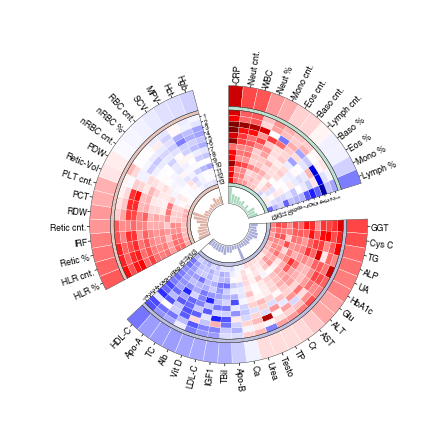

In [38]:
from pycirclize import Circos
import numpy as np

color_list = ['#A8D9BF','#A7ABD6','#DFB2A6']
sectors = {"A": 12, "B": 23, "C": 17}
circos = Circos(sectors, space=15, start=0)
vmin1, vmax1 = w.min().min(), w.max().max()
vmin2, vmax2 = w_all.min().min(), w_all.max().max()

vmin1, vmax1 = w.max().max()*-1, w.max().max()
vmin2, vmax2 =  w_all.max().max()*-1, w_all.max().max()

vmin2, vmax2 =  -.125, .125

# width of edge lines (default 0.5)
lw = 0.25
# vmin2, vmax2 = w_all.min().min() - .5, w_all.max().max() + .5
for idx,sector in enumerate(circos.sectors):
    
    # Plot avg Dx heatmap
    track1 = sector.add_track((85, 100))
    track1.axis(lw=lw)
    data = w_list[idx].values
    track1.heatmap(data, cmap="seismic", vmin=vmin2, vmax=vmax2, show_value=False, rect_kws=dict(ec="white", lw=.25), text_kws=dict(size=4.5))
    major_xticks = np.arange(0, sector.end, 1) + .5
    track1.xticks(major_xticks,labels=w_list[idx].rename(columns=blood_dic).columns,label_orientation='vertical',label_size=6.25)
    
    # Plot all Dx heatmap with labels
    track2 = sector.add_track((30, 82.5))
    track2.axis(lw=lw)
    data = w_all_list[idx].values
    track2.heatmap(data, cmap="seismic", vmin=vmin2, vmax=vmax2, rect_kws=dict(ec="white", lw=.15))
    track2.yticks([i - 0.5 for i in range(1,14)], [str(i) for i in range(1,14)][::-1], vmin=0, vmax=13, label_size=4.85)
    
    # Plot Dx std bar track
    bar_track = sector.add_track((15, 27.5), r_pad_ratio=0.1)
    bar_track.axis(lw=lw)
    x = np.arange(sector.start, sector.end) + 0.5
    y = w_all_std_list[idx].values
    # bar_track.bar(x, y, color=color_list[idx])
    bar_track.bar(x, y, color=color_list[idx])
    
    # color track
    color_track = sector.add_track((27.5,30))
    color_track.axis(fc=color_list[idx], alpha=0.75,lw=lw)
    color_track2 = sector.add_track((82.5, 85))
    color_track2.axis(fc=color_list[idx], alpha=0.75,lw=lw)

        
# circos.colorbar(bounds=(0.35, 0.55, 0.3, 0.01), vmin=vmin1, vmax=vmax1, orientation="horizontal")
# circos.colorbar(bounds=(0.35, 0.5, 0.3, 0.01), vmin=vmin2, vmax=vmax2, orientation="horizontal")

fig = circos.plotfig()
# fig.set_size_inches(3.6, 3.6)
fig.set_size_inches(3.675, 3.675)

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_4_Composite_sig/circos_plot.pdf", 
# dpi=300, transparent=True, bbox_inches='tight')


## Extracting model performance metrics

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

def compute_roc_scores(dic, pain_nci, UKB, NCI, T2=False):
    
    if T2 == True:
        T = 'T2'
    else:
        T = 'T0'
        
    # Taking AUC from merged folds (NCI + CP)
    n_iterations = 1
    n_folds = 5
    rocs = np.zeros(shape=(n_iterations, len(pain_nci)))

    def extract_iteration_and_fold(key):
        parts = key.split('_')
        iter_idx = int(parts[-2].split('-')[-1])
        fold_idx = int(parts[-1].split('-')[-1])
        return iter_idx, fold_idx

    for idx1, n in enumerate(pain_nci):
        for iteration in range(n_iterations):
            iteration_rocs = []

            for fold in range(n_folds):
                # Filter dictionary keys based on the current iteration and fold
                filtered_keys = [key for key in dic.keys() if extract_iteration_and_fold(key) == (iteration, fold)]

                for key in filtered_keys:
                    value = dic[key]

                    # Create tmp df including predicted probs and ncis in each fold
                    tmp = pd.DataFrame((value['roc_curve']), index=['eid', 'True', 'Prob']).T
                    tmp = tmp.merge(UKB[['eid', f'NumberChronicPainTypes_{T}']], on='eid')  # Merge pain phenotype
                    tmp = tmp.merge(NCI[['eid'] + pain_nci], on='eid')  # Merge pain ncis

                    # Select only nci == 1 or pain == 0
                    ncis = tmp[(tmp[n] == 1) | (tmp[f'NumberChronicPainTypes_{T}'] == 0)]
                    # Select only nci with CP
                    drop_eid = ncis[(ncis[n] == 1) & (ncis[f'NumberChronicPainTypes_{T}'] == 0)].eid
                    ncis = ncis[~ncis.eid.isin(drop_eid)]

                    # Instantiate array with case values and predicted probabilities
                    iteration_rocs.append(pd.concat([ncis[n], ncis.Prob], axis=1))

            # Merge the data from the 5 folds for the current iteration
            merged_iteration_rocs = pd.concat(iteration_rocs)
            # Compute the ROC score from the merged data and store it in the rocs array
            rocs[iteration, idx1] = roc_auc_score(merged_iteration_rocs[n], merged_iteration_rocs['Prob'])

    return rocs

# Example usage:
filtered_dict = {key: value for key, value in diag_T0.items() if 'Blood' in key}
# rocs = compute_roc_scores(filtered_dict, nci_cols_t0[:2], UKB, NCI, T2=False)


In [23]:

from scipy.stats import ttest_ind
from scipy.stats import ranksums

def cohens_d_and_pvalue(series1, series2):
    """
    Compute Cohen's d and p-value.

    Args:
        series1 (pd.Series): Pandas Series 1
        series2 (pd.Series): Pandas Series 2

    Returns:
        float, float: Cohen's d, p-value
    """
    # calculate the mean of each series
    mean1, mean2 = series1.mean(), series2.mean()

    # calculate the variance of each series
    var1, var2 = series1.var(), series2.var()

    # number of observations in each series
    n1, n2 = len(series1), len(series2)

    # calculate the pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # calculate Cohen's d
    d = (mean1 - mean2) / pooled_std

    # compute the t-statistic and p-value
    t_stat, p_value = ranksums(series1, series2)

    return d, p_value


ncis = [i.split('_')[1] for i in nci_cols_t2]

modalities = ['T1','DWI','fMRI','Bone']
# modalities = ['Blood','Metabolomics','PRS','Sparse']

cohens_d_df = pd.DataFrame(index=ncis, columns=modalities)
p_values_df = pd.DataFrame(index=ncis, columns=modalities)  # dataframe for storing p-values

for nci in ncis:

    for modality in modalities:
        df = pd.concat([pd.DataFrame(diag_T2[i]['roc_curve'],index=['eid',nci,'Prob']).T for i in diag_T2 if f'{nci}_{modality}' in i]).reset_index(drop=True)
        
        case = df[(df[f'{nci}'] == 1)]['Prob']
        control = df[(df[f'{nci}'] == 0)]['Prob']
        cohend, p_value = cohens_d_and_pvalue(case,control)  # get both cohens d and p-value

        # Store the values in the dataframes
        cohens_d_df.loc[nci, modality] = cohend
        p_values_df.loc[nci, modality] = p_value  # store the p-value


In [24]:
def pivot_pickle(df,cols):
    
    T0_cat = pd.concat([df[i]['results_df'] for i in df.keys()])
    T0_cat.index = [i[:-4] for i in T0_cat.index]
    T0_auc = T0_cat.groupby(level=0).mean().AUC_test
    ind = np.unique([i.split('_')[1:-1][0] for i in T0_auc.index])
    df = pd.concat([T0_auc[T0_auc.index.str.contains(i)].reset_index(drop=True) for i in cols],axis=1)
    df.index = ind
    df.columns = cols
    
    return df

T0_auc = pivot_pickle(diag_T0,cols=['Blood','PRS','Psychosocial'])
T2_auc = pivot_pickle(diag_T2,cols=['T1','DWI','fMRI','Stacked','Bone','Biology'])
merged_auc = pd.concat([T0_auc,T2_auc],axis=1).reindex([i.split('_')[1:-1][0] for i in nci_cols_t0])


# Marker Signature

In [25]:
# Get feature names from each modality
fmri_cols = diag_T2['NCI_fibromyalgia_fMRI_Iter-0_Fold-0']['weights'][0].index
t1_cols = diag_T2['NCI_fibromyalgia_T1_Iter-0_Fold-0']['weights'][0].index
dwi_cols = diag_T2['NCI_fibromyalgia_DWI_Iter-0_Fold-0']['weights'][0].index
stacked_cols = diag_T2['NCI_fibromyalgia_Stacked_Iter-0_Fold-0']['weights'][0].index
bone_cols = diag_T2['NCI_fibromyalgia_Bone_Iter-0_Fold-0']['weights'][0].index
blood_cols = diag_T0['NCI_fibromyalgia_Blood_Iter-0_Fold-0']['weights'][0].index

In [ ]:
# Load in demographic, diagnosis, and pain data

home_dir = '/Users/Patty/Desktop/EVP_lab/'

cols_t0 = [
        'ChronicPain_T0',
        'ChronicWidespreadPain_T0', 
        'ChronicHeadaches_T0',
        'ChronicNeckShoulderPain_T0', 
        'ChronicHipPain_T0', 
        'ChronicBackPain_T0', 
        'ChronicStomachAbdominalPain_T0', 
        'ChronicKneePain_T0',
        'ChronicFacialPain_T0', 
        'NumberChronicPainTypes_T0',
        'Age_T0',
        'OverallHealthRating_T0',
        'UnableWorkDueSicknessDisability_T0'
]
cols_t1 = [i.replace('T0','T1') for i in cols_t0]
cols_t2 = [i.replace('T0','T2') for i in cols_t0]

cols = ['eid', 'Sex_T0'] + cols_t0 + cols_t1 + cols_t2
UKB = pd.read_csv(home_dir + 'UKB_NoBrain_500K_V4.csv',low_memory=False,usecols=cols) #UKB demographic data

# NCI Data
NCI = pd.read_csv(home_dir + 'NCI_combined.csv')
UKB = UKB.merge(NCI,on='eid')
# NCI combinations

UKB['NCI_Free_T0'] = np.where(UKB.NCI_T0 == 0,1,0)
UKB['NCI_Free_T1'] = np.where(UKB.NCI_T1 == 0,1,0)
UKB['NCI_Free_T2'] = np.where(UKB.NCI_T2 == 0,1,0)
UKB['NCI_Free_T3'] = np.where(UKB.NCI_T3 == 0,1,0)

In [31]:
home_dir = '/Users/Patty/Desktop/EVP_lab/'

UKB_T3 = pd.read_csv('/Users/Patty/Desktop/EVP_lab/UKB_demos_confounds_T3.csv')
UKB = UKB.merge(UKB_T3,on='eid',how='outer')

# # Adjust for WSP and calculate spreading
UKB.loc[UKB['ChronicWidespreadPain_T0'] == 1, 'NumberChronicPainTypes_T0'] = 7
UKB.loc[UKB['ChronicWidespreadPain_T1'] == 1, 'NumberChronicPainTypes_T1'] = 7
UKB.loc[UKB['ChronicWidespreadPain_T2'] == 1, 'NumberChronicPainTypes_T2'] = 7
UKB.loc[UKB['ChronicWidespreadPain_T3'] == 1, 'NumberChronicPainTypes_T3'] = 7

UKB['Spread_T1'] = UKB['NumberChronicPainTypes_T1'] - UKB['NumberChronicPainTypes_T0']
UKB['Spread_T2'] = UKB['NumberChronicPainTypes_T2'] - UKB['NumberChronicPainTypes_T0']
UKB['Spread_T3'] = UKB['NumberChronicPainTypes_T3'] - UKB['NumberChronicPainTypes_T2']

# Cap pain at 4 sites
UKB.loc[UKB['NumberChronicPainTypes_T0'] > 4, 'NumberChronicPainTypes_T0'] = 4
UKB.loc[UKB['NumberChronicPainTypes_T1'] > 4, 'NumberChronicPainTypes_T1'] = 4
UKB.loc[UKB['NumberChronicPainTypes_T2'] > 4, 'NumberChronicPainTypes_T2'] = 4
UKB.loc[UKB['NumberChronicPainTypes_T3'] > 4, 'NumberChronicPainTypes_T3'] = 4

In [32]:
def transform_blood_data(blood, log=True):
    """
    Impute missing values with the median and apply log transformation to all columns except the first one,
    using log1p if zeros are present in the feature.
    
    Parameters:
    - blood (pd.DataFrame): Input DataFrame with blood data.
    
    Returns:
    - pd.DataFrame: Transformed blood data.
    """
    
    # Impute missing values with median
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    blood_data = pd.DataFrame(imp_med.fit_transform(blood), columns=blood.columns)
    
    # Apply log transformation as required
    if log:
        for column in blood_data.columns[1:]:  # Exclude the first column (subject ID)
            if (blood_data[column] == 0).any():  # Check if there are zero values in the column
                blood_data[column] = np.log1p(blood_data[column])
            else:
                # Avoid taking log of zero or negative values by adding 1
                blood_data[column] = np.log(blood_data[column])
    
    return blood_data

In [33]:
from sklearn.impute import SimpleImputer
from confounds import Residualize

def transform_blood_data(blood, log=True):
    """
    Impute missing values with the median and apply log transformation to all columns except the first one,
    using log1p if zeros are present in the feature.
    
    Parameters:
    - blood (pd.DataFrame): Input DataFrame with blood data.
    
    Returns:
    - pd.DataFrame: Transformed blood data.
    """
    
    # Impute missing values with median
    imp_med = SimpleImputer(missing_values=np.nan, strategy='median')
    blood_data = pd.DataFrame(imp_med.fit_transform(blood), columns=blood.columns)
    
    # Apply log transformation as required
    if log:
        for column in blood_data.columns[1:]:  # Exclude the first column (subject ID)
            if (blood_data[column] == 0).any():  # Check if there are zero values in the column
                blood_data[column] = np.log1p(blood_data[column])
            else:
                # Avoid taking log of zero or negative values by adding 1
                blood_data[column] = np.log(blood_data[column])
    
    return blood_data

blood = pd.read_csv(home_dir + 'UKB_New_Blood_Immuno_T0.csv')
threshold = len(blood.columns) / 2 
blood = blood.dropna(thresh=threshold) # Drop subjects missing >= 50% of features
blood_data = transform_blood_data(blood)
# T1
blood_t1 = pd.read_csv(home_dir + 'UKB_New_Blood_Immuno_T1.csv').dropna(thresh=threshold) # Drop subjects missing >= 50% of features
blood_t1 = transform_blood_data(blood_t1)

# Align column names
UKB['Age_D'] = UKB['Age_T1'] - UKB['Age_T0']
column_names = [col.replace('T0', 'T1') for col in blood_data.columns]
blood_t1 = blood_t1[column_names]

# Remove urine assays
blood_data = blood_data.drop(columns=['Sodium_T0', 'Potassium_T0'])
blood_t1 = blood_t1.drop(columns=['Sodium_T1', 'Potassium_T1'])

# Create columns for subjects who develop or maintain a Dx or stay healthy

In [34]:
# Extract unique disease names from one of the lists
disease_names = [col.replace("_T0", "") for col in nci_cols_t0]

# Define the pairs of timepoints to compare
timepoint_pairs = [('T0', 'T1'), ('T0', 'T2'), ('T2', 'T3')]
timepoint_pairs

for disease in disease_names:
    for tp1, tp2 in timepoint_pairs:
        # Developed disease between tp1 and tp2
        developed_col = f'{disease}_developed_{tp1}_to_{tp2}'
        UKB[developed_col] = ((UKB[f'{disease}_{tp1}'] == 0) & (UKB[f'{disease}_{tp2}'] == 1)).astype(int)
        
        # Maintained disease between tp1 and tp2
        maintained_col = f'{disease}_maintained_{tp1}_to_{tp2}'
        UKB[maintained_col] = ((UKB[f'{disease}_{tp1}'] == 1) & (UKB[f'{disease}_{tp2}'] == 1)).astype(int)
        
        # Healthy at both timepoints
        healthy_col = f'healthy_{tp1}_and_{tp2}'
        UKB[healthy_col] = ((UKB[f'NCI_Free_{tp1}'] == 1) & (UKB[f'NCI_Free_{tp2}'] == 1)).astype(int)

# Now, UKB dataframe has the required new columns.


# Change in pain for Dx developments

In [35]:
import numpy as np

def bootstrap_confidence_interval(data, num_samples=100, alpha=0.1):
    """
    Compute confidence interval using bootstrapping.
    
    Parameters:
    - data: array-like, the dataset for which CI is calculated.
    - num_samples: int, number of bootstrap samples to generate.
    - alpha: float, significance level (0.05 for 95% CI, 0.01 for 99% CI).
    
    Returns:
    - tuple, (lower bound, upper bound) of the confidence interval.
    """
    n = len(data)
    means = np.array([np.random.choice(data, size=n, replace=True).mean() for _ in range(num_samples)])
    return np.percentile(means, [100 * alpha / 2., 100 * (1 - alpha / 2.)])

# Subjects who remained healthy
healthy_changes = UKB.loc[UKB['healthy_T0_and_T2'] == 1, 'Spread_T2']
mean_healthy_change = healthy_changes.mean()
ci_healthy_change = bootstrap_confidence_interval(healthy_changes, num_samples=100, alpha=0.05)

# Dictionaries to store the results
avg_pain_changes = {}
ci_pain_changes = {}
colors = {}
p_values = {}

for disease in disease_names:
    developed_col = f'{disease}_developed_T0_to_T2'
    healthy_col = f'healthy_T0_and_T2'
    
    # Subjects who developed the disease
    developed_changes = UKB.loc[UKB[developed_col] == 1, 'Spread_T2']
    avg_change = developed_changes.mean()
    avg_pain_changes[disease] = avg_change
    ci_pain_changes[disease] = bootstrap_confidence_interval(developed_changes, num_samples=100, alpha=0.05)
    
    # T-test to check significance between the developed and healthy group
    _, p_value = stats.ttest_ind(developed_changes, healthy_changes)
    p_values[disease] = p_value
    
    # Determine the color of the bar
    if p_value < 0.05:  # Assuming a significance level of 0.05
        colors[disease] = 'blue' if avg_change < 0 else 'red'
    else:
        colors[disease] = 'grey'


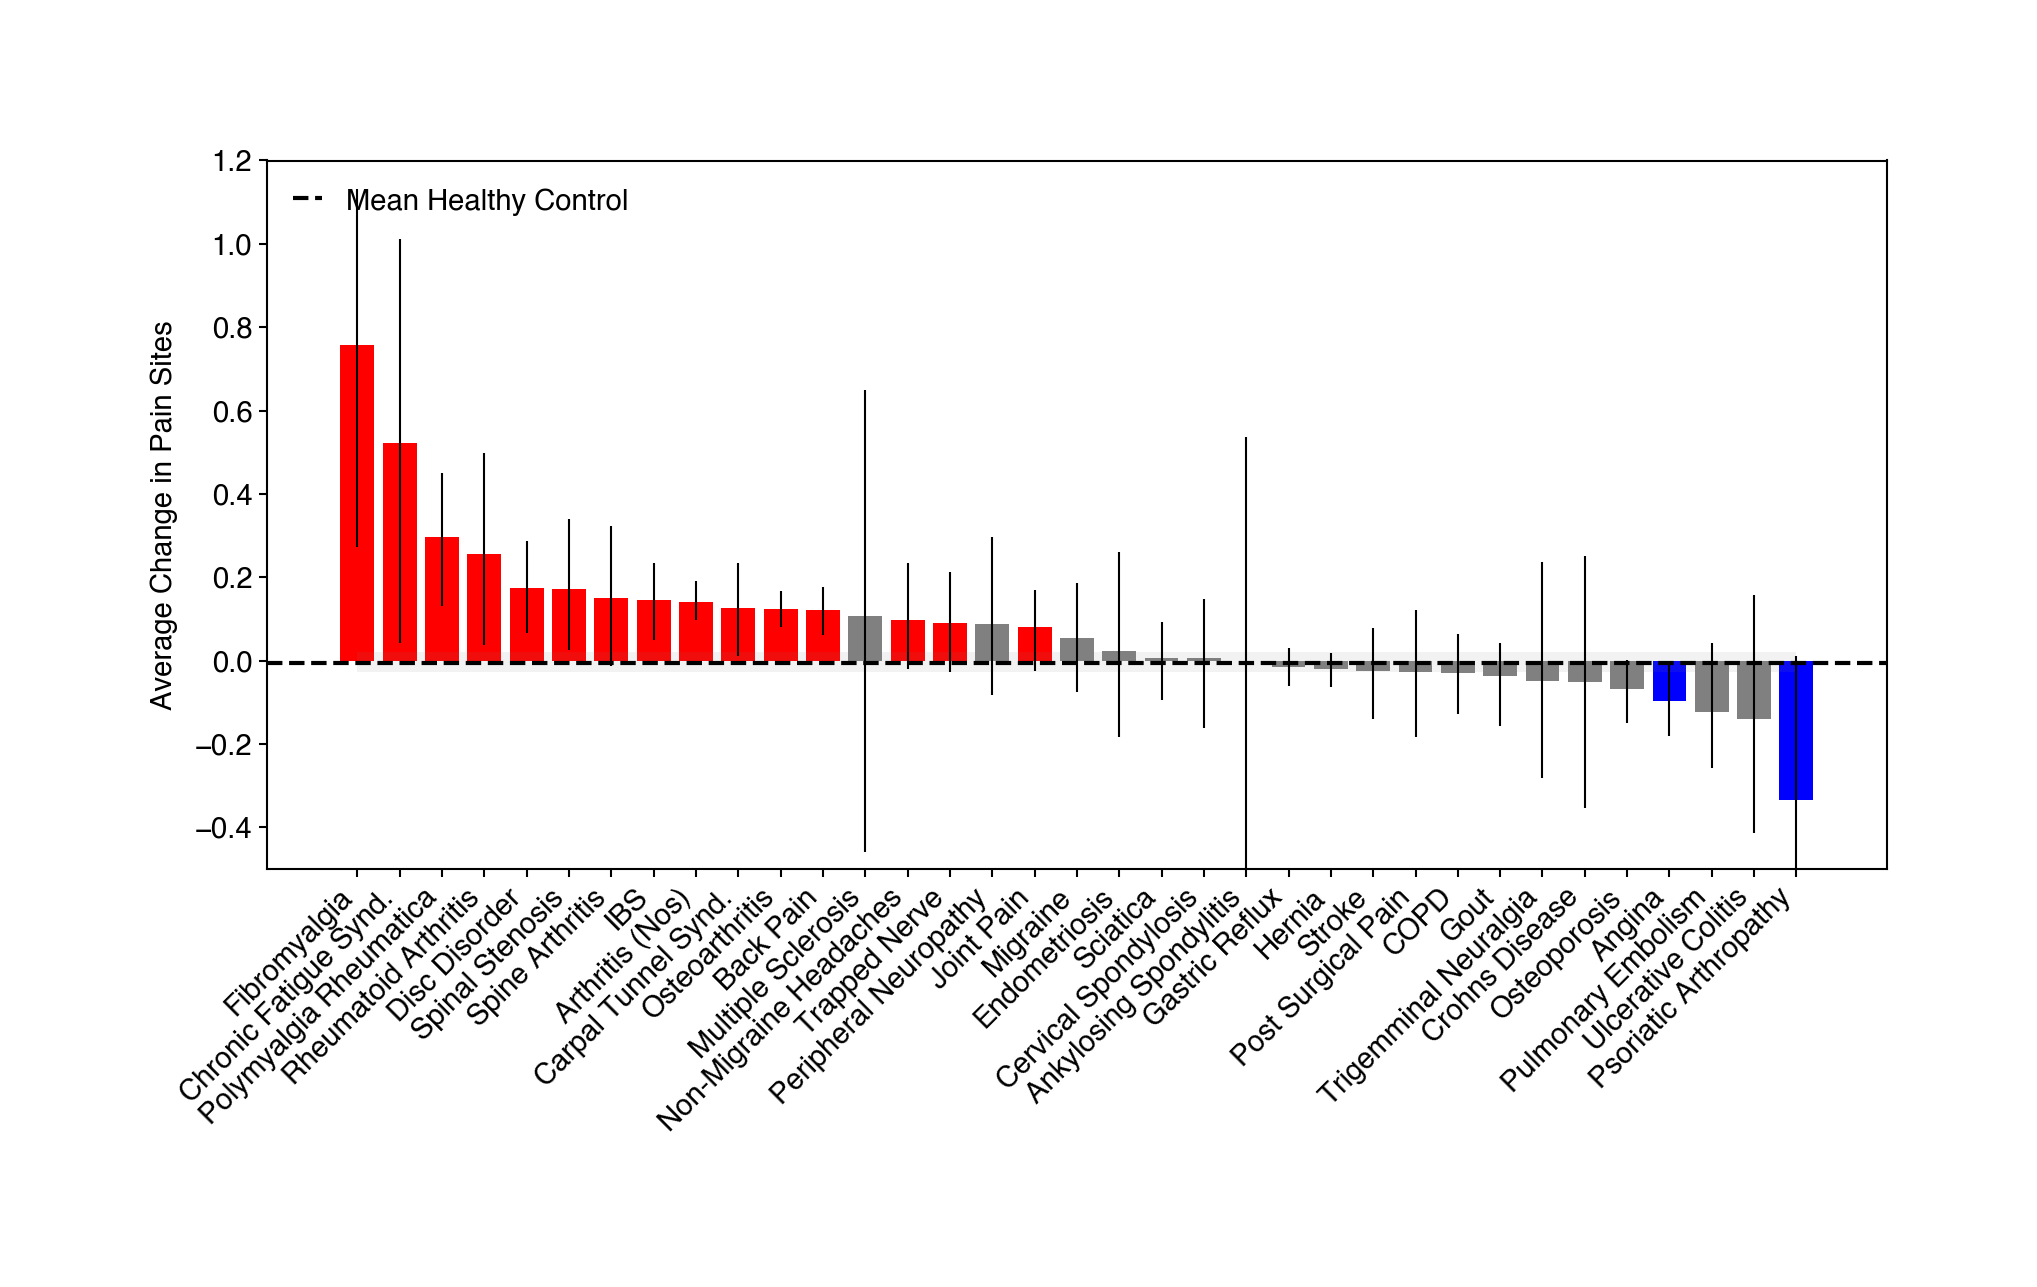

In [37]:
# Compute error values (distance from mean to CI bounds) for plotting
error_values = {disease: (avg_pain_changes[disease] - ci[0], ci[1] - avg_pain_changes[disease]) 
                for disease, ci in ci_pain_changes.items()}

import matplotlib.pyplot as plt

diseases = list(avg_pain_changes.keys())
xl_names = [rename[d] for d in [i[4:] for i in diseases]]
avg_values = list(avg_pain_changes.values())
errors = [error_values[disease] for disease in diseases]  # Extracting error values
bar_colors = list(colors.values())

# Zip together diseases, avg_values, errors, bar_colors, and disease_names
zipped = list(zip(diseases, avg_values, errors, bar_colors, xl_names))
# Sort by avg_values in descending order
sorted_data = sorted(zipped, key=lambda x: x[1], reverse=True)
# Unzip sorted data
sorted_diseases, sorted_avg_values, sorted_errors, sorted_colors, sorted_disease_names = zip(*sorted_data)

# Plotting
fig, ax = plt.subplots(figsize=(6,3.5))

ax.bar(range(len(sorted_diseases)), sorted_avg_values, yerr=np.array(sorted_errors).T, color=sorted_colors, capsize=0)
ax.axhline(mean_healthy_change, color='black', linestyle='--', label='Mean Healthy Control', lw=1)
ax.fill_between(range(len(sorted_diseases)), ci_healthy_change[0], ci_healthy_change[1], color='grey', alpha=0.1)

ax.set_ylim(-0.5,1.2)
ax.set_ylabel('Average Change in Pain Sites')
ax.set_xticks(range(len(sorted_diseases)))
ax.set_xticklabels(sorted_disease_names, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()


## Calculating composite blood assay signature and evaluating its performance on 13 conditions

In [39]:
# Function to extract predicted probabilities from models
def merge_dataframe(dic, nci, mod1, mod2):
    a_data = [pd.DataFrame(dic[i]['roc_curve'].T, columns=['eid',f'y_true_{mod1}',f'{nci}_{mod1}']) for i in dic.keys() if f'{nci}_{mod1}' in i]
    a_data_o = pd.concat([pd.DataFrame(dic[i]['roc_curve_other'].T, columns=['eid',f'y_true_{mod1}',f'{nci}_{mod1}']) for i in dic.keys() if f'{nci}_{mod1}' in i])
    a = pd.concat([pd.concat(a_data), a_data_o]).groupby('eid').mean()
    a.columns = ['Dx',mod1]

    merged_df = a.copy()
    merged_df[mod1] = np.log(merged_df[mod1] / (1 - merged_df[mod1]))
    merged_df.columns = [nci,nci+'_'+mod1]
    
    # Add longitudinal
    a_data_l = pd.concat([pd.DataFrame(dic[i]['roc_curve_longitudinal'].T, columns=['eid',f'{nci}_{mod1}_l']) for i in dic.keys() if f'{nci}_{mod1}' in i]).groupby('eid').mean()
    merged_df = merged_df.merge(a_data_l,on='eid',how='outer')
    
    merged_df[f'{nci}_{mod1}_l'] = np.log(merged_df[f'{nci}_{mod1}_l'] / (1 - merged_df[f'{nci}_{mod1}_l']))
    merged_df = merged_df.dropna(subset=nci+'_'+mod1) # drop subjects with mising T0

    return merged_df


In [40]:
diseases = list(avg_pain_changes.keys())
all_diagnoses = [i[4:] for i in diseases]

merged_dfs = []

mod1 = 'Blood'
mod2 = 'Psychosocial'
# Generate merged dataframe for each diagnosis
for diagnosis in all_diagnoses:
    df = merge_dataframe(diag_T0, diagnosis, mod1, mod2)
    merged_dfs.append(df)

# Concatenate all dataframes
final_df = pd.concat(merged_dfs, axis=1)
final_df = final_df.merge(UKB,on='eid')
final_df['dx_t0'] = final_df[[i for i in merged_auc.sort_values('Blood', ascending=False).index[:13]]].max(axis=1)

In [42]:
top_blood = merged_auc.sort_values('Blood',ascending=False).index[:13]
# top_psych = merged_auc.sort_values('Psychosocial',ascending=False).index[:20]

final_df['composite_Blood_T0'] = final_df[[i+'_Blood' for i in top_blood]].mean(axis=1)
# final_df['composite_Psychosocial_T0'] = final_df[[i+'_Psychosocial' for i in top_psych]].mean(axis=1)

final_df['composite_Blood_T1'] = final_df[[i+'_Blood_l' for i in top_blood]].mean(axis=1)
# final_df['composite_Psychosocial_T1'] = final_df[[i+'_Psychosocial_l' for i in top_psych]].mean(axis=1)

# Initialize the columns with zeros
final_df['blood_maintained_T0_to_T1'] = 0
final_df['blood_developed_T0_to_T1'] = 0
final_df['blood_developed_T0_to_T2'] = 0

# Loop through each disease in top_blood and update the corresponding columns
for dx in top_blood:
    maintained_col = f'NCI_{dx}_maintained_T0_to_T1'
    developed_t1_col = f'NCI_{dx}_developed_T0_to_T1'
    developed_t2_col = f'NCI_{dx}_developed_T0_to_T2'
    present_t1_col = f'NCI_{dx}_T1'

    
    # Update the maintained_T0_to_T1 column
    condition_maintained = (final_df[maintained_col] == 1)
    final_df.loc[condition_maintained, 'blood_maintained_T0_to_T1'] = 1
    
    # Update the developed_T0_to_T1 column
    condition_developed_t1 = (final_df[developed_t1_col] == 1)
    final_df.loc[condition_developed_t1, 'blood_developed_T0_to_T1'] = 1
    
    # Update the developed_T0_to_T2 column
    condition_developed_t2 = (final_df[developed_t2_col] == 1) & (final_df[present_t1_col] == 0)
    final_df.loc[condition_developed_t2, 'blood_developed_T0_to_T2'] = 1


In [43]:
from confounds import Residualize
import pandas as pd
from scipy.stats import zscore
import numpy as np

# Initialize Residualize
resid = Residualize()

# Extract top blood markers and create coefficient matrix 'w' from structure coefficients
top_blood = [i+'_Blood' for i in merged_auc.sort_values('Blood', ascending=False).index[:13]] # Take blood with AUC > .7
w = pd.concat([diag_T0[i]['weights'][1] for i in diag_T0 if any(t in i for t in top_blood)]).groupby(level=0, sort=False).mean()
w = w[~w.index.isin(['Sodium_T0', 'Potassium_T0'])] # remove urine assays
  
def process_blood_data(blood_df, additional_cols, weight_matrix):
    # Merge and select relevant data
    blood_tmp = blood_df.merge(UKB[additional_cols], on='eid')
    
    # Standardize blood data and fit the residualizer
    X = zscore(blood_tmp.iloc[:, 1:-len(additional_cols)+1])
    y = blood_tmp[additional_cols[:-1]].values  # Exclude 'eid' from the covariates
    resid.fit(X, y)
    
    # Transform data and calculate signature
    X_resid = resid.transform(X, y)
    # weight_matrix = zscore(weight_matrix)
    dot_product = np.dot(X_resid, weight_matrix)
    blood_tmp['sig'] = zscore(dot_product)
    
    return blood_tmp

# Process T0 and T1 data
blood_tmp_T0 = process_blood_data(blood_data, ['Age_T0', 'Sex_T0', 'eid'], w)
blood_tmp_T1 = process_blood_data(blood_t1, ['Age_T1', 'Sex_T0', 'eid'], w)
blood_tmp_T1 = blood_tmp_T1.rename(columns={'sig': 'sig_t1'})

# Merge signatures with the final dataframe
full_df = final_df.merge(blood_tmp_T0[['eid', 'sig']], on='eid', how='outer')
full_df = full_df.merge(blood_tmp_T1[['eid', 'sig_t1']], on='eid', how='outer')
full_df = full_df.dropna(subset='dx_t0')

In [45]:
# Calculate cohens d confidence intervals for each pain condition group vs controls based on composite sig, also calculate AUC score

def cohen_d(series1, series2):

    # calculate the mean of each series
    mean1, mean2 = series1.mean(), series2.mean()
    # calculate the variance of each series
    var1, var2 = series1.var(), series2.var()
    # number of observations in each series
    n1, n2 = len(series1), len(series2)
    # calculate the pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))  
    # calculate Cohen's d
    d = (mean1 - mean2) / pooled_std

    return d

# Initialize an empty dataframe to store the AUC and Cohen's d values
all_bootstrap_results = pd.DataFrame()
# List of top 13 Dx included in composite signature
top_dx = [i for i in merged_auc.sort_values('Blood', ascending=False).index[:13]] # Take blood with AUC > .7
res = 1000
# For each diagnosis, compute the AUC values and add them to the dataframe
for diagnosis in top_dx[:]:
    
    dx = f'NCI_{diagnosis}_T0'
    cs_df = full_df[(full_df[diagnosis] == 1) | (full_df['NCI_T0'] == 0)].dropna(subset=f'{diagnosis}_Blood')
    t1_df = full_df[(full_df[f'healthy_T0_and_T1'] == 1) | (full_df[f'NCI_{diagnosis}_developed_T0_to_T1'] == 1)]
    t1_df = t1_df[t1_df['dx_t0'] == 0]
    t2_df = full_df[(full_df[f'healthy_T0_and_T2'] == 1) | (full_df[f'NCI_{diagnosis}_developed_T0_to_T2'] == 1)]
    t2_df = t2_df[t2_df['dx_t0'] == 0]
    
    # Calculate sample sizes for each group at each timepoint
    n_cs = cs_df[dx].sum()
    n_t1 = t1_df[f'NCI_{diagnosis}_developed_T0_to_T1'].sum()
    n_t2 = t2_df[f'NCI_{diagnosis}_developed_T0_to_T2'].sum()
    
    # Creating case and control groups for each timepoint
    cs_dx, cs_hc = cs_df[cs_df[dx] == 1]['sig'], cs_df[cs_df[dx] == 0]['sig']
    t1_dx, t1_hc = t1_df[t1_df[f'NCI_{diagnosis}_developed_T0_to_T1'] == 1]['sig'], t1_df[t1_df[f'NCI_{diagnosis}_developed_T0_to_T1'] == 0]['sig']
    t2_dx, t2_hc = t2_df[t2_df[f'NCI_{diagnosis}_developed_T0_to_T2'] == 1]['sig'], t2_df[t2_df[f'NCI_{diagnosis}_developed_T0_to_T2'] == 0]['sig']
    
    # Compute the observed AUC and Cohen's d for the original dataset
    cd_cs, auc_cs = cohen_d(cs_dx, cs_hc), roc_auc_score(cs_df[dx], cs_df['sig'])
    cd_t1, auc_t1 = cohen_d(t1_dx, t1_hc), roc_auc_score(t1_df[f'NCI_{diagnosis}_developed_T0_to_T1'], t1_df['sig'])
    cd_t2, auc_t2 = cohen_d(t2_dx, t2_hc), roc_auc_score(t2_df[f'NCI_{diagnosis}_developed_T0_to_T2'], t2_df['sig'])

    # Compute bootstrapped CI for cohens d
    bs_cs = stats.bootstrap((cs_dx, cs_hc), cohen_d, confidence_level=0.95,method='percentile',random_state=1,n_resamples=res,vectorized=False)
    bs_t1 = stats.bootstrap((t1_dx, t1_hc), cohen_d, confidence_level=0.95,method='percentile',random_state=1,n_resamples=res,vectorized=False)
    bs_t2 = stats.bootstrap((t2_dx, t2_hc), cohen_d, confidence_level=0.95,method='percentile',random_state=1,n_resamples=res,vectorized=False)
    # Upper and lower CI
    h_cs,l_cs = bs_cs.confidence_interval[:]
    h_t1,l_t1 = bs_t1.confidence_interval[:]
    h_t2,l_t2 = bs_t2.confidence_interval[:]
    # Distribution
    dist_cs = bs_cs.bootstrap_distribution
    dist_t1 = bs_t1.bootstrap_distribution
    dist_t2 = bs_t2.bootstrap_distribution
    
    # Store all bootstrap results in dataframe along with the sample size
    for timepoint, auc, cohend, cohend_l, cohend_h, n_size in [('T0', auc_cs, dist_cs, h_cs, l_cs, n_cs),
                                                         ('T1', auc_t1, dist_t1, h_t1, l_t1, n_t1),
                                                         ('T2', auc_t2, dist_t2, h_t2, l_t2, n_t2)]:
        
        for boot_index in range(res):
            all_bootstrap_results = all_bootstrap_results.append({
                'Diagnosis': rename.get(diagnosis, diagnosis),
                'Timepoint': timepoint,
                'AUC': auc,
                'CohenD': cohend[boot_index],
                'CI_lower': cohend_l,
                'CI_upper': cohend_h,
                'Sample_Size': n_size
            }, ignore_index=True)

auc_long = all_bootstrap_results[['Diagnosis','Timepoint','AUC']]
auc_pivot = auc_long.pivot_table(index='Timepoint', columns='Diagnosis', values='AUC', aggfunc='mean')

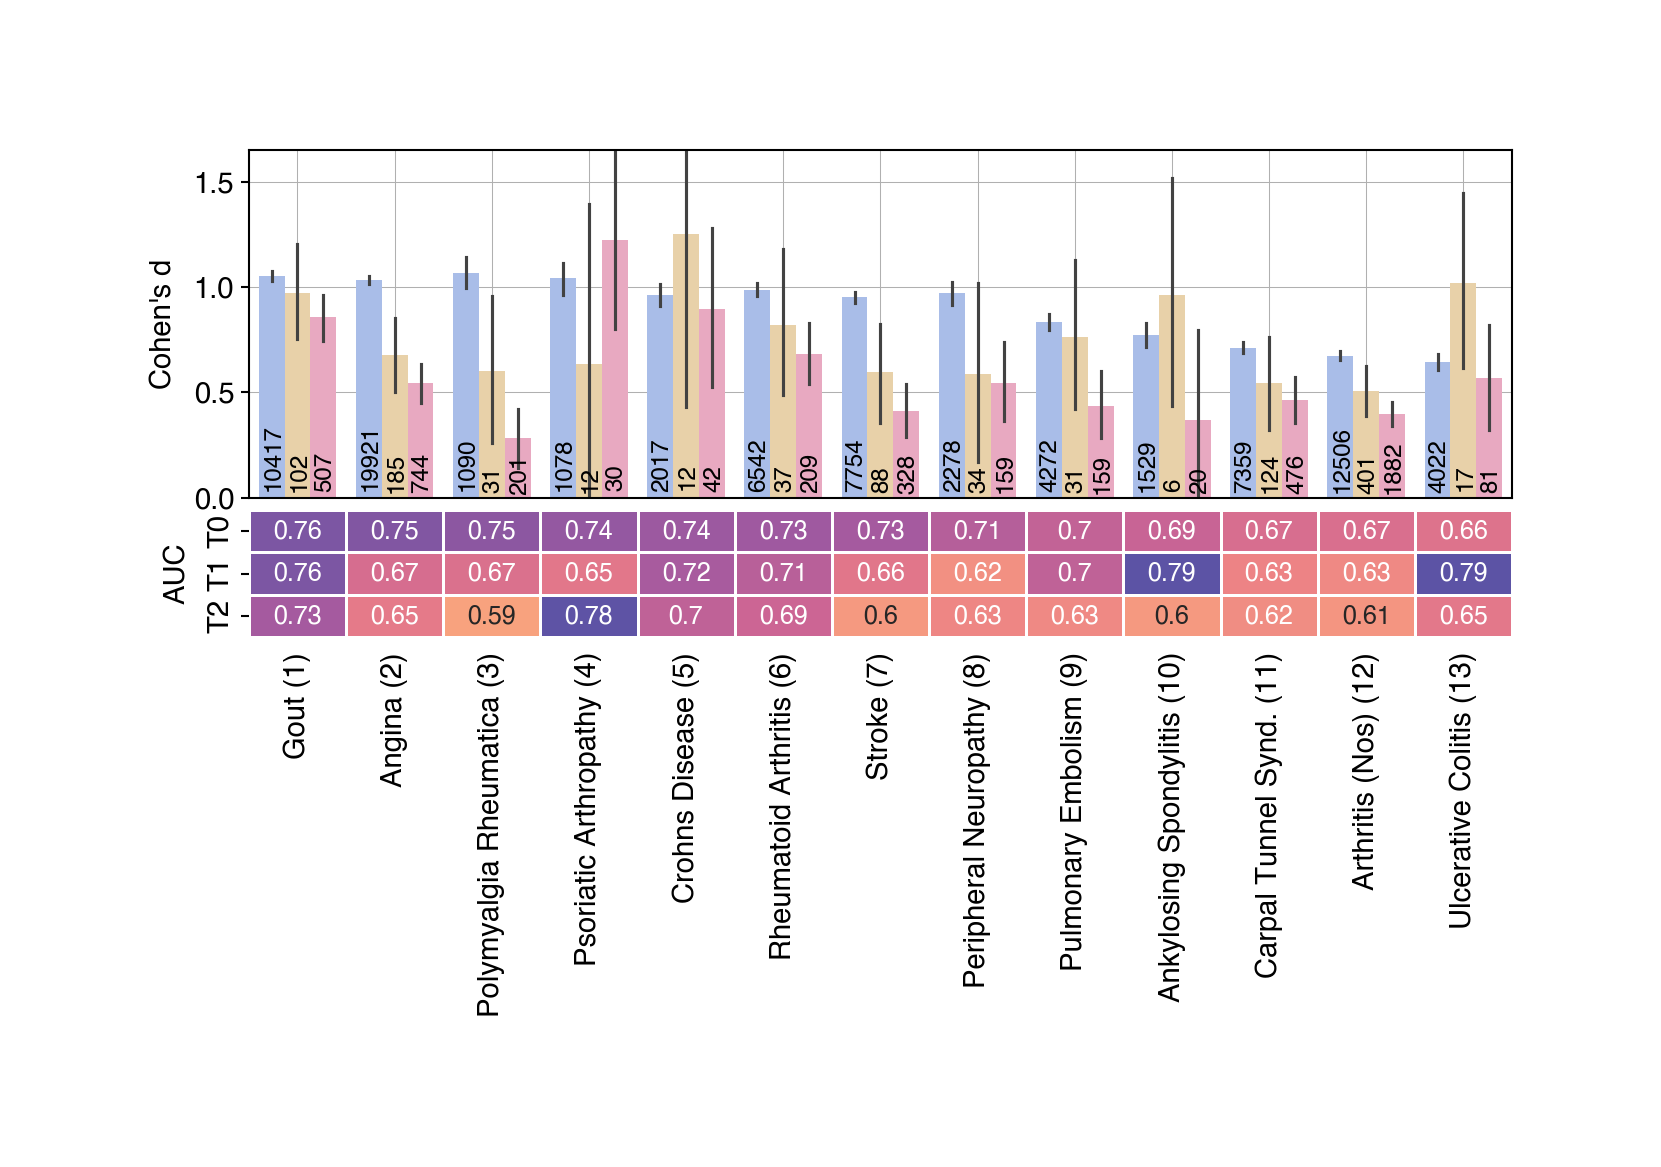

In [46]:
# Plot cohens d + 95% CI and AUC scores for composite sig for all groups

x_labels = [
        'Psoriatic arthropathy', 'Gout', 'Angina',
       'Polymyalgia rheumatica', 'Crohns disease', 'Rheumatoid arthritis',
       'Peripheral neuropathy', 'Stroke', 'Pulmonary embolism',
       'Ankylosing spondylitis', 'Carpal tunnel synd.', 'Arthritis',
       'Ulcerative colitis'
           ]

# Calculate mean AUC score for each diagnosis at Timepoint T0
mean_auc_t0 = all_bootstrap_results[all_bootstrap_results['Timepoint'] == 'T0'].groupby('Diagnosis')['AUC'].mean().sort_values(ascending=False)
# Create a sorting key that will be used to order the Diagnosis on the plots
sorting_key = mean_auc_t0.index.tolist()
# Use the 'category' data type to impose a meaningful order on the 'Diagnosis' column based on the sorting key
cohens_df = all_bootstrap_results[['Diagnosis','Timepoint','CohenD']]
cohens_df['Diagnosis'] = pd.Categorical(cohens_df['Diagnosis'], categories=sorting_key, ordered=True)
auc_df = all_bootstrap_results[['Diagnosis','Timepoint','AUC']]
auc_df['Diagnosis'] = pd.Categorical(auc_df['Diagnosis'], categories=sorting_key, ordered=True)
auc_long = auc_df[['Diagnosis','Timepoint','AUC']]
auc_pivot = auc_long.pivot_table(index='Timepoint', columns='Diagnosis', values='AUC', aggfunc='mean')
# Sort the dataframes
cohens_df = cohens_df.sort_values('Diagnosis')
auc_df = auc_df.sort_values('Diagnosis')
timepoint_order = ['T0', 'T1', 'T2']
custom_palette = ['#9EB9F3', '#F3D49E', '#F39EBF'] # Analagous

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 1, figsize=(4.75, 3.1), sharex=False, gridspec_kw={'height_ratios': [3, 1.1]})

# Create the barplot for Cohen's D values
barplot = sns.barplot(
    x='Diagnosis', 
    y='CohenD', 
    hue='Timepoint', 
    data=cohens_df, 
    ax=axes[0], 
    hue_order=timepoint_order,
    palette=custom_palette,
    # gap=0.1,
    errorbar=lambda x: (np.percentile(x,2.5), np.percentile(x,97.5)),
    err_kws = {'linewidth':.75,'zorder':1}
)
    
n_df = all_bootstrap_results[['Diagnosis','Timepoint','Sample_Size']]
n_df['Diagnosis'] = pd.Categorical(n_df['Diagnosis'], categories=sorting_key, ordered=True)
avg_sample_size = n_df.groupby(['Diagnosis','Timepoint']).mean().reset_index().sort_values(by=['Timepoint', 'Diagnosis'])
# Iterate over the bars in the barplot and add a vertical text annotation for each bar's sample size
for bar, (index, row) in zip(barplot.patches, avg_sample_size.iterrows()):
    # The x position of the text will be the center of the bar
    text_x = bar.get_x() + bar.get_width() / 2
    # The y position of the text will be slightly above the base of the bar (adjust if necessary)
    text_y = bar.get_height() * 0.02
    # The sample size text
    sample_size_text = str(int(row['Sample_Size']))
    # Adding the text annotation to the bar
    axes[0].text(
        text_x+0.02, text_y+0.01, sample_size_text, 
        rotation=90, 
        ha='center', va='bottom', 
        fontsize=5.8, color='black',zorder=5
    )

axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('Cohen\'s d')
axes[0].set_ylim(0,1.65)
axes[0].set_yticks([0.0,0.5,1.0,1.5])

# Add grids
axes[0].grid(True,linewidth=.25,zorder=-10)
axes[0].set_axisbelow(True)

# Adjust the legend
# Adjust the legend
axes[0].legend('',frameon=False)
axes[1].legend('',frameon=False)

axes[0].tick_params(axis='x',  
                    which='both',      
                    bottom=False,      
                    top=False,       
                    labelbottom=False)
# Adjust the legend
import palettable
cmap = palettable.cartocolors.sequential.Sunset_7.mpl_colormap

auc_pivot.columns = [i+f' ({idx+1})' for idx,i in enumerate(auc_pivot.columns)]
sns.heatmap(auc_pivot,linewidth=.35,cbar=False,
           cmap=cmap,vmin=0.5,vmax=0.78,annot=True,annot_kws={'fontsize':6})
axes[1].set_xlabel('')
axes[1].set_ylabel('AUC')
# axes[1].set_xticklabels(x_labels,rotation=90)
axes[1].tick_params(axis='x',  
                    which='both',      
                    bottom=False,      
                    top=False,
                    left=False,
                    labelleft=False,
                    labelbottom=True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.show()
# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_4_Blood_lng/composite_bars.pdf", 
# dpi=300, transparent=True, bbox_inches='tight')

### Pooled predictive performance

In [47]:
top_dx = [i for i in merged_auc.sort_values('Blood', ascending=False).index[:13]] # Take blood with AUC > .7

df_t0 = full_df[top_dx+['eid','sig','sig_t1','NCI_Free_T0','dx_t0']]
df_t0['dx_t0'] = np.where(df_t0[top_dx].sum(axis=1) > 0, 1, 0)

top_t1 = ['NCI_'+i+'_developed_T0_to_T1' for i in top_dx]
df_t1 = full_df[top_t1+['eid','sig','sig_t1','healthy_T0_and_T1','dx_t0']]
df_t1['dx_t1'] = np.where(df_t1[top_t1].sum(axis=1) > 0, 1, 0)
df_t1 = df_t1[df_t1['dx_t0'] == 0]

top_t2 = ['NCI_'+i+'_developed_T0_to_T2' for i in top_dx]
df_t2 = full_df[top_t2+['eid','sig','sig_t1','healthy_T0_and_T2','dx_t0']]
df_t2['dx_t2'] = np.where(df_t2[top_t2].sum(axis=1) > 0, 1, 0)
df_t2 = df_t2[df_t2['dx_t0'] == 0]

dx_df = df_t0[['eid','dx_t0','NCI_Free_T0','sig_t1','sig']].merge(df_t1[['eid','dx_t1','healthy_T0_and_T1']],on='eid',how='outer').merge(df_t2[['eid','dx_t2','healthy_T0_and_T2']],on='eid',how='outer')


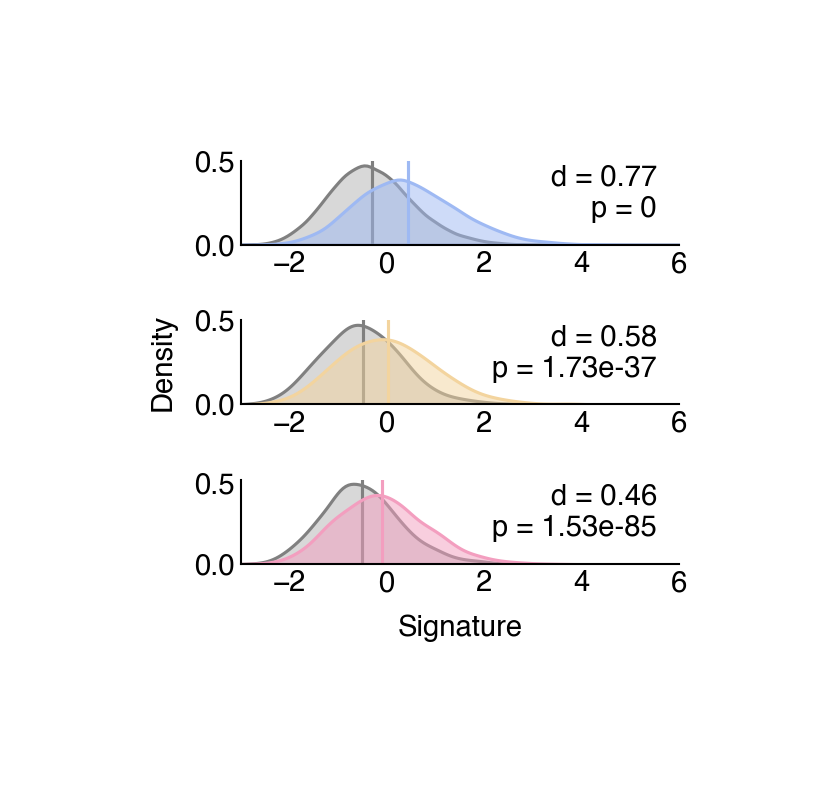

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create sub-dataframes for plotting
data_t0 = [dx_df[dx_df['dx_t0'] == 1].sig, dx_df[dx_df['NCI_Free_T0'] == 1].sig]
data_t1 = [dx_df[dx_df['dx_t1'] == 1].sig, dx_df[dx_df['healthy_T0_and_T1'] == 1].sig]
data_t2 = [dx_df[dx_df['dx_t2'] == 1].sig, dx_df[dx_df['healthy_T0_and_T2'] == 1].sig]

cd_t0,p_t0 = cohens_d_and_pvalue(dx_df[dx_df['dx_t0'] == 1].sig, dx_df[dx_df['NCI_Free_T0'] == 1].sig)
cd_t1,p_t1 = cohens_d_and_pvalue(dx_df[dx_df['dx_t1'] == 1].sig, dx_df[dx_df['healthy_T0_and_T1'] == 1].sig)
cd_t2,p_t2 = cohens_d_and_pvalue(dx_df[dx_df['dx_t2'] == 1].sig, dx_df[dx_df['healthy_T0_and_T2'] == 1].sig)

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 1, figsize=(2, 1.85))

custom_palette = ['#9EB9F3', '#F3D49E', '#F39EBF'] # Analagous

# Plot each distribution
for i, data in enumerate([data_t0, data_t1, data_t2]):

    sns.kdeplot(data[0], color=custom_palette[i], label=None, fill=True, bw_adjust=1.25, ax=axes[i], alpha=.5, linewidth=.75)
    sns.kdeplot(data[1], color="grey", label=None, fill=True, bw_adjust=1.25, ax=axes[i], alpha=.3, linewidth=.75, zorder=-1)
    
    # Draw a vertical line at the mean of the data for each group
    mean_diagnosed = np.mean(data[0])
    mean_healthy = np.mean(data[1])
    axes[i].axvline(mean_healthy, color='grey', linestyle='-', linewidth=.75, zorder=-1)
    axes[i].axvline(mean_diagnosed, color=custom_palette[i], linestyle='-', linewidth=.75)

    # Remove gridlines for a cleaner look
    axes[i].grid(False)

    # Remove x and y ticks for a cleaner look
    axes[i].tick_params(axis='both', which='both', length=0)
    
    # Remove spines for a cleaner look
    sns.despine(ax=axes[i], top=True, right=True, left=False, bottom=False)

    axes[i].set_xlim(-3,6)

    axes[i].tick_params(axis='x', labelsize=7)
    axes[i].tick_params(axis='y', labelsize=7)
    axes[i].set_yticks([0,.5])
    
    # Remove the legend
    axes[i].legend('',frameon=False)

    axes[i].set_title('')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # Add Cohen's d and p-value in the top right corner
    ax = axes[i]
    text_str = f"d = {cd_t0:.2f}\np = {p_t0:.3g}" if i == 0 else \
               f"d = {cd_t1:.2f}\np = {p_t1:.3g}" if i == 1 else \
               f"d = {cd_t2:.2f}\np = {p_t2:.3g}"
    ax.text(0.95, 0.95, text_str, transform=ax.transAxes, ha='right', va='top', fontsize=7)

axes[1].set_ylabel('Density')
axes[2].set_xlabel('Signature')
plt.tight_layout()
plt.show()

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_4_Blood_lng/cohen_kde.pdf", 
# dpi=300, transparent=True, bbox_inches='tight')

## Assessing disease trajectories using longitudinal data in subset with repeat blood draw using mixed linear models

In [49]:
top_dx = [
 'gout',
 'polymyalgia rheumatica',
 'stroke',
 'crohns disease',
 'angina',
 'rheumatoid arthritis',
 'psoriatic arthropathy',
 'peripheral neuropathy',
 'ankylosing spondylitis',
 'carpal tunnel syndrome',
 'pulmonary embolism +/- dvt',
 'ulcerative colitis',
 'arthritis (nos)'
         ]

In [50]:
# Initialize Residualize
resid = Residualize()

# Extract top blood markers and create weight matrix 'w'
top_blood = [i+'_Blood' for i in merged_auc.sort_values('Blood', ascending=False).index[:13]] # Take blood with AUC > .7
w = pd.concat([diag_T0[i]['weights'][1] for i in diag_T0 if any(t in i for t in top_blood)]).groupby(level=0, sort=False).mean()
w = w[~w.index.isin(['Sodium_T0', 'Potassium_T0'])] # remove urine assays

def process_blood_data(blood_df, additional_cols, weight_matrix):
    # Merge and select relevant data
    blood_tmp = blood_df.merge(UKB[additional_cols], on='eid')
    
    # Standardize blood data and fit the residualizer
    X = zscore(blood_tmp.iloc[:, 1:-len(additional_cols)+1])
    y = blood_tmp[additional_cols[:-1]].values  # Exclude 'eid' from the covariates
    resid.fit(X, y)
    
    # Transform data and calculate signature
    X_resid = zscore(resid.transform(X, y))
    weight_matrix = zscore(weight_matrix)
    dot_product = zscore(np.dot(X_resid, weight_matrix))
    blood_tmp['sig'] = dot_product
    
    return blood_tmp

# Process T0 and T1 data
blood_tmp_T0 = process_blood_data(blood_data, ['Age_T0', 'Sex_T0', 'eid'], w)
blood_tmp_T1 = process_blood_data(blood_t1, ['Age_T1', 'Sex_T0', 'eid'], w)
blood_tmp_T1 = blood_tmp_T1.rename(columns={'sig': 'sig_t1'})

# Merge signatures with the final dataframe
full_df = final_df.merge(blood_tmp_T0[['eid', 'sig']], on='eid', how='outer')
full_df = full_df.merge(blood_tmp_T1[['eid', 'sig_t1']], on='eid', how='outer')

In [51]:
tmp = full_df.dropna(subset='sig_t1')
tmp.sig = tmp.sig.fillna(np.mean(tmp.sig))
tmp = tmp[['eid','sig','sig_t1']].merge(UKB,on='eid')
tmp['Age_D'] = tmp.Age_T1 - tmp.Age_T0
tmp['change'] = tmp.sig_t1 - tmp.sig

def regress_out_age(df, column):
    X = sm.add_constant(df[['Age_T1','Age_T0','Age_D','Sex_T0']])  # Independent variable (age) with a constant term
    y = df[column]  # Dependent variable (signature)
    model = sm.OLS(y, X).fit()  # Fit linear regression model
    return model.resid  # Return residuals

# Regress age out of 'sig' and 'sig_t1'
# tmp['sig'] = regress_out_age(tmp, 'sig')
# tmp['sig_t1'] = regress_out_age(tmp, 'sig_t1')
# tmp['change'] = regress_out_age(tmp, 'change')

top_dx_tmp = ['NCI_'+i+'_T0' for i in top_dx]
df_t0 = tmp[top_dx_tmp+['eid','sig','sig_t1','NCI_Free_T0','Age_T0','Age_T1','Age_D','Sex_T0','change']]
# df_t0 = tmp[top_dx+['eid','sig','sig_t1','NCI_Free_T0','Age_T0','Age_T1','Age_D','Sex_T0','change','Med_C10A_T1']]
df_t0['dx_t0'] = np.where(df_t0[top_dx_tmp].sum(axis=1) > 0, 1, 0)

top_t1 = ['NCI_'+i+'_developed_T0_to_T1' for i in top_dx]
df_t1 = tmp[top_t1+['eid','sig','sig_t1','healthy_T0_and_T1']]
df_t1['dx_t1'] = np.where(df_t1[top_t1].sum(axis=1) > 0, 1, 0)

top_t2 = ['NCI_'+i+'_developed_T0_to_T2' for i in top_dx]
df_t2 = tmp[top_t2+['eid','sig','sig_t1','healthy_T0_and_T2']]
df_t2['dx_t2'] = np.where(df_t2[top_t2].sum(axis=1) > 0, 1, 0)

dx_df = df_t0[['eid','dx_t0','NCI_Free_T0','sig_t1','sig','Age_T0','Age_T1','Age_D','Sex_T0','change']].merge(df_t1[['eid','dx_t1','healthy_T0_and_T1']],on='eid',how='outer').merge(df_t2[['eid','dx_t2','healthy_T0_and_T2']],on='eid',how='outer')


In [52]:
# Filtering based on the groups
healthy_df = dx_df[(dx_df['healthy_T0_and_T1'] == 1) & (dx_df['dx_t2'] != 1)]
maintainers_df = dx_df[dx_df['dx_t0'] == 1]
developers_df = dx_df[(dx_df['dx_t0'] == 0) & (dx_df['dx_t1'] == 1)]
t2_developers_df = dx_df[(dx_df['dx_t0'] == 0) & (dx_df['dx_t1'] == 0) & (dx_df['dx_t2'] == 1)]

healthy_change = (healthy_df['sig_t1'] - healthy_df['sig']).mean()
maintainter_change = (maintainers_df['sig_t1'] - maintainers_df['sig']).mean()
developers_change = (developers_df['sig_t1'] - developers_df['sig']).mean()
t2_developers_change = (t2_developers_df['sig_t1'] - t2_developers_df['sig']).mean()

In [53]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM

# Step 1: Combine datasets
# Add a 'Group' column to each DataFrame to indicate group membership
maintainers_df['Group'] = 'Disease'
developers_df['Group'] = 'Develop_t1'
t2_developers_df['Group'] = 'Develop_t2'
healthy_df['Group'] = 'Healthy'

# Combine all DataFrames into one
combined_df = pd.concat([maintainers_df, developers_df, t2_developers_df, healthy_df], ignore_index=True)

# Step 2: Reshape data to long format
combined_long_df = pd.melt(combined_df, id_vars=['eid', 'Group'], value_vars=['sig', 'sig_t1'],
                           var_name='Timepoint', value_name='sig_Level')

# Convert 'Timepoint' to a categorical variable representing baseline and follow-up
combined_long_df['Timepoint'] = combined_long_df['Timepoint'].map({'sig': 'Baseline', 'sig_t1': 'Follow_Up'})



In [55]:
import pandas as pd
import statsmodels.formula.api as smf

# Assuming 'combined_long_df' is your long-format DataFrame prepared earlier

# List of disease groups for comparison
disease_groups = ['Disease', 'Develop_t1', 'Develop_t2']

# Loop through each disease group to compare with the healthy control group
for disease_group in disease_groups:
    
    # Filter the DataFrame for the disease group and the healthy control group
    analysis_df = combined_long_df[combined_long_df['Group'].isin([disease_group, 'Healthy'])]
    
    # Recode the 'Group' variable to binary (1 for disease group, 0 for healthy control)
    analysis_df['Group'] = analysis_df['Group'].map({disease_group: 1, 'Healthy': 0})
    
    # Specify the linear mixed-effects model
    model = smf.mixedlm("sig_Level ~ Timepoint * Group", analysis_df, groups=analysis_df["eid"], re_formula="1")
    
    # Fit the model
    result = model.fit()
    
    # Print the model summary
    print(f"Analysis for {disease_group} vs. Healthy Control:\n")
    print(result.summary())
    print("\n" + "-"*80 + "\n")


Analysis for Disease vs. Healthy Control:

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      sig_Level  
No. Observations:      8166         Method:                  REML       
No. Groups:            4083         Scale:                   0.3901     
Min. group size:       2            Log-Likelihood:          -10689.1957
Max. group size:       2            Converged:               Yes        
Mean group size:       2.0                                              
------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                    -0.438    0.028 -15.558 0.000 -0.493 -0.383
Timepoint[T.Follow_Up]        0.082    0.025   3.305 0.001  0.033  0.130
Group                         0.665    0.034  19.546 0.000  0.598  0.731
Timepoint[T.Follow_Up]:Gro

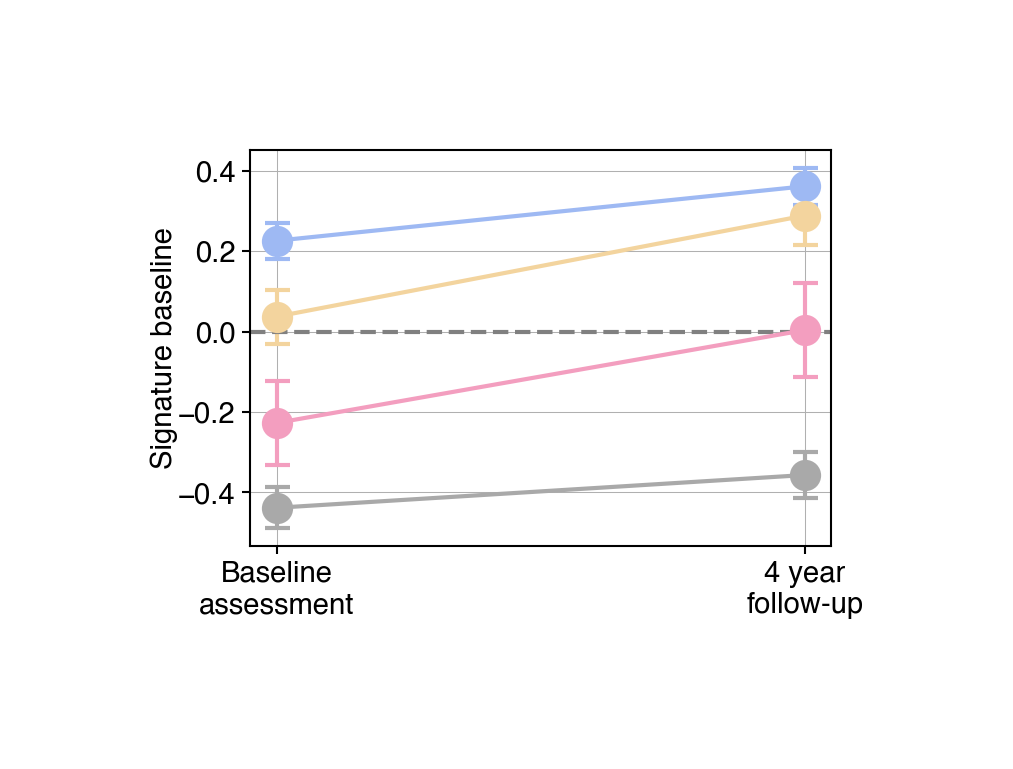

In [58]:
# Adjusting the code to plot the 95% confidence interval instead of the SEM

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, t
import numpy as np

# Define timepoints for plotting
timepoints = ['Baseline\nassessment', '4 year\nfollow-up']

# Define custom color palette
custom_palette = ['#9EB9F3', '#F3D49E', '#F39EBF', '#A9A9A9']  # Analogous

# Function to calculate the mean and 95% CI
def get_mean_and_95CI(df, column):
    data = df[column].dropna()
    mean = data.mean()
    ci = t.interval(0.975, len(data)-1, loc=mean, scale=sem(data))
    error = (ci[1] - mean, mean - ci[0])  # Upper and lower bounds
    return mean, error

# Create the figure
fig, ax = plt.subplots(figsize=(2.5, 1.75))

# Plotting the mean trajectory for each group with 95% CI as error bars
for idx, (group_df, group_label, percent_change) in enumerate(zip(
    [maintainers_df, developers_df, t2_developers_df, healthy_df],
    ['Maintain', 'Develop 3 years', 'Develop 9 years', 'Healthy'],
    [maintainter_change, developers_change, t2_developers_change, healthy_change]
)):
    mean_t0, ci_t0 = get_mean_and_95CI(group_df, 'sig')
    mean_t1, ci_t1 = get_mean_and_95CI(group_df, 'sig_t1')
    
    plt.errorbar(timepoints, [mean_t0, mean_t1], yerr=np.array([ci_t0, ci_t1]).T, label=group_label,
                 marker='o', markersize=6.5, capsize=3, elinewidth=1, linewidth=1,
                 color=custom_palette[idx])

# Providing additional information
plt.yticks([-0.4,-0.2,0,0.2,0.4])
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.ylabel('Signature baseline',labelpad=0)
plt.legend('', frameon=False)
plt.grid(True, linewidth=.25)

# Show the plot
plt.show()
# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_4_Blood_lng/trajectories_pooled.pdf", 
# dpi=300, transparent=True, bbox_inches='tight')